In [20]:
import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
from qiskit import Aer
from utils.dnn import *
from utils.data_encoders import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Post selection non-linearity

In [21]:
def non_linearity(x, weights, shots=1000):
    n = weights.shape[0]
    
    storage = qk.QuantumRegister(n, name="storage")
    ancilla = qk.QuantumRegister(1, name="ancilla")
    clas_reg = qk.ClassicalRegister(2, name="clas_reg")
    registers = [storage, ancilla, clas_reg]
    circuit = qk.QuantumCircuit(*registers)

    circuit.ry(x, storage[0])
    circuit.barrier()

    for i in range(n - 1):
        circuit.cx(storage[i], storage[i + 1])

    circuit.barrier()

    for i, w in enumerate(weights):
        circuit.ry(2*w, storage[i])

    circuit.barrier()    

    for i in range(n - 1):
        circuit.cx(storage[i], storage[i + 1])

    circuit.barrier()
    circuit.mcrx(np.pi, storage[:-1], ancilla[0])
    circuit.barrier()

    circuit.measure([storage[-1], ancilla[0]], clas_reg)
    
    job = qk.execute(circuit, backend, shots=1000)
    result = job.result()
    counts = result.get_counts(circuit)
    
    states = ["00", "01", "10", "11"]
    
    for state in states:
        if state not in counts:
            counts[state] = 0
        
    return np.sqrt((counts["10"] + counts["11"])/shots), np.sqrt((counts["11"])/(counts["01"] + counts["11"]))

In [22]:
np.random.seed(42)
backend = Aer.get_backend('qasm_simulator')

n = 3
weights = np.random.uniform(0, np.pi, n)

In [23]:
X = np.linspace(0, np.pi, 30)
Y1 = []
Y2 = []
for x in X:
    y1, y2 = non_linearity(x, weights, shots=10000)
    Y1.append(y1)
    Y2.append(y2)

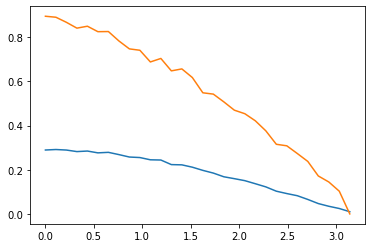

In [24]:
plt.plot(X,Y1)
plt.plot(X,Y2)
plt.show()